In [1]:
# imports
import cv2 # opencv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
from dataset_generator import get_waldorf_statler_mfcc_features, create_kermit_image_dataset

# definitons of constants/variables
video_file_glob_path = '../../videos/*.avi'
audio_base_path = '../../audio/'
kermit_data_path = '../../ground_truth/kermit/'
kermit_label_file = kermit_data_path + 'labels.txt'
evaluation_base_path = '../../evaluation/'

label_map = {0: 'kermit_the_frog',
             1: 'waldorf_and_statler',
             2: 'pig',
             3: 'swedish_chef',
             4: 'none'}

In [2]:
# this section hold useful helper functions and transformers for classifying kermit

# method for image resizing and extracting vector of raw values
def extract_value_vector(image, size=(128, 128)):
    return cv2.resize(image, size).flatten()

def extract_colour_histogram(image, bins=(32, 32, 32)):
    # convert image to hsv space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # extract color histogram from image and take all 3 channels into account
    color_hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    
    # normalize resulting histogram
    cv2.normalize(color_hist, color_hist)
    
    # print resulting historgram
    # plt.hist(image.ravel(),256,[0,256])
    # cols = ('b', 'g', 'r')
    # for i, col in enumerate(cols):
    #     histr = cv2.calcHist([image],[i],None,[256],[0,256])
    #     plt.plot(histr,color = col)
    #     plt.xlim([0,256])
    # plt.show()
    
    # return histogram as feature vector
    return color_hist.flatten()
    

def load_kermit_image_dataset():
    kermit_data = pd.DataFrame([], columns=['name', 'filename', 'kermit'])

    with open(kermit_label_file) as file:
        for i, line in enumerate(file):
            if i == 0:
                continue
            splits = list(map(lambda line: line.strip(), line.split(",")))
            name = splits[0] + '_' + splits[1]
            labels = [int(splits[i]) for i in range(2, len(splits)) if int(splits[i]) != 4]
        
            filename = kermit_data_path + name + '_' + splits[2] + '.jpg'
            kermit_data = kermit_data.append({'name': name,
                                            'file_id': int(splits[0]),
                                            'filename': filename,
                                            'kermit': 1 if 0 in labels else 0}, ignore_index=True)
    return kermit_data


def train_test_validation_split(df):
    video1_df = df[df['file_id'] == 1]
    video2_df = df[df['file_id'] == 2]
    video3_df = df[df['file_id'] == 3]
    
    train_v1_df, test_v1_df, val_v1_df = np.split(video1_df.sample(frac=1, random_state=42), [int(.6*len(video1_df)), int(.8*len(video1_df))])
    train_v2_df, test_v2_df, val_v2_df = np.split(video2_df.sample(frac=1, random_state=42), [int(.6*len(video2_df)), int(.8*len(video2_df))]) 
    train_v3_df, test_v3_df, val_v3_df = np.split(video3_df.sample(frac=1, random_state=42), [int(.6*len(video3_df)), int(.8*len(video3_df))]) 
    
    train_df = pd.concat([train_v1_df, train_v2_df, train_v3_df]).reset_index(drop=True)
    test_df = pd.concat([test_v1_df, test_v2_df, test_v3_df]).reset_index(drop=True)
    val_df = pd.concat([val_v1_df, val_v2_df, val_v3_df]).reset_index(drop=True)
    
    return train_df, test_df, val_df


In [6]:
# create kermit image dataset if not exists (this is checked by the function itself)
create_kermit_image_dataset()

# after dataset creation, load it into dataframe
df_kermit = load_kermit_image_dataset()

Number of samples per character in ground truth:
kermit_the_frog: 2663
waldorf_and_statler: 301
pig: 1548
swedish_chef: 220
none: 5712
total_samples: 10444
[INFO] Start extracting images for target class: 0
[INFO] Start extracting randomly sampled images


In [5]:
## Preprocessing and splitting data for Kermit
df_kermit_cp = df_kermit.copy()

# init data structures for feature vectors, image pixel values and labels
hist_features = []
images_raw_pixels = []

print('[INFO] start preprocessing images (color histogram)')

counter = 1
# iterate over all provided images and extract features, labels and image pixels
for idx, row in df_kermit_cp.iterrows():
    img = cv2.imread(row['filename'])
    
    # extract color distribution of the image
    img_color_hist = extract_colour_histogram(img)
    
    # extract raw pixels of the image
    img_pixels = extract_value_vector(img)

    hist_features.append(img_color_hist)
    images_raw_pixels.append(img_pixels)
    
    # show process
    if counter % 200 == 0:
        print('[INFO] images preprocessed %d/%d' % (counter, len(df_kermit_cp)))
    counter += 1
    
# add feature lists as new cols to dataframe
df_pre = df_kermit_cp.assign(color_hist = hist_features)
df_kermit_features = df_pre.assign(raw_pixels = images_raw_pixels)

# split dataframe into train, test and validation set
train, test, validation = train_test_validation_split(df_kermit_features)

# extract specific columns used for classification
x_train_raw = train['raw_pixels'].tolist()
x_train_hist = train['color_hist'].tolist()
y_train = train['kermit'].tolist()

x_test_raw = test['raw_pixels'].tolist()
x_test_hist = test['color_hist'].tolist()
y_test = test['kermit'].tolist()

x_validation_raw = validation['raw_pixels'].tolist()
x_validation_hist = validation['color_hist'].tolist()
y_validation = validation['kermit'].tolist()


[INFO] start preprocessing images (color histogram)


In [8]:
# train a KNN classifier on raw pixel data
model_raw = KNeighborsClassifier(n_neighbors=20)
model_raw.fit(x_train_raw, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

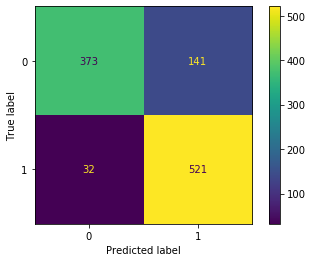

In [11]:
# print confusion matrix for KNN classifier trained on raw pixels
plot_confusion_matrix(model_raw, x_test_raw, y_test, values_format='d')
plt.show()

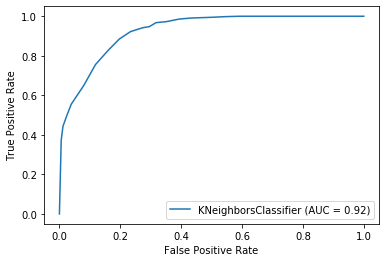

In [12]:
# print roc curve for KNN classifier trained on raw pixels
plot_roc_curve(model_raw, x_test_raw, y_test)
plt.show()

In [13]:
# train a KNN classifier on histogram features
model_hist = KNeighborsClassifier(n_neighbors=20)
model_hist.fit(x_train_hist, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

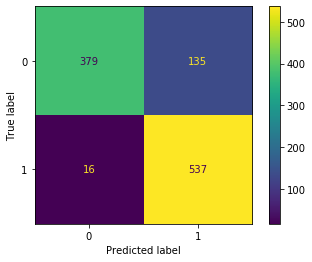

In [14]:
plot_confusion_matrix(model_hist, x_test_hist, y_test, values_format='d')
plt.show()

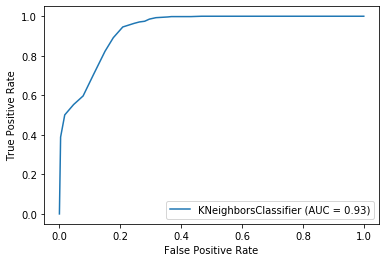

In [15]:
plot_roc_curve(model_hist, x_test_hist, y_test)
plt.show()

In [26]:
## Identifying Waldorf/Statler
# loading the already preprocessed MFCC feature dataset into dataframe
frame_length_ms = 20
n_mfcc_coeffs = 20
ws_raw_data = get_waldorf_statler_mfcc_features(frame_length_ms, n_mfcc_coeffs)
df_ws =  pd.DataFrame(ws_raw_data, columns=['label', 'file_id', 'mfcc'])
df_ws

Total number of audio snippets: 374
Window size: 20 ms
Number of MFCC features: 20
Extracting MFCC features for audio data...
Write extracted MFCCs to file: ../../ground_truth/audio/mfcc.txt
Read MFCC features for random sampling...
Number of samples for target class 1: 9428
Create data distribution map...
Successfully extracted MFCC feature dataset for character: 1


,label,file_id,mfcc
0,1,1,"[-514.52264, 72.68069, -7.8223343, 16.554436, ..."
1,1,1,"[-437.11847, 123.634605, -21.206165, 18.731792..."
2,1,1,"[-415.42236, 103.66402, -48.647392, 19.857784,..."
3,1,1,"[-357.4835, 81.216515, -50.17099, 16.521435, 4..."
4,1,1,"[-317.0375, 60.61718, -23.854359, 34.73358, 29..."
...,...,...,...
18857,0,3,"[-349.2266, -50.239677, 13.375766, 48.38742, 5..."
18858,0,3,"[-266.08246, 113.620636, -8.417058, 3.288989, ..."
18859,0,3,"[-406.05002, 129.82576, -23.376585, -6.6268616..."
18860,0,3,"[-468.2055, 97.083374, -33.85717, 8.294485, 8...."


In [27]:
# split dataframe into train, test and validation set
train, test, validation = train_test_validation_split(df_ws)

# extract specific columns used for classification
x_train_mfcc = train['mfcc'].tolist()
y_train_mfcc = train['label'].tolist()

x_test_mfcc = test['mfcc'].tolist()
y_test_mfcc = test['label'].tolist()

x_validation_mfcc = validation['mfcc'].tolist()
y_validation_mfcc = validation['label'].tolist()

In [28]:
# train a random forest classifier on mfcc features
ws_rf_cls = RandomForestClassifier(n_estimators=150)
ws_rf_cls.fit(x_train_mfcc, y_train_mfcc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

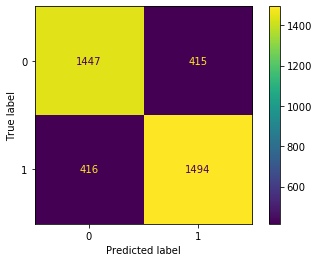

In [29]:
plot_confusion_matrix(ws_rf_cls, x_test_mfcc, y_test_mfcc, values_format='d')
plt.show()

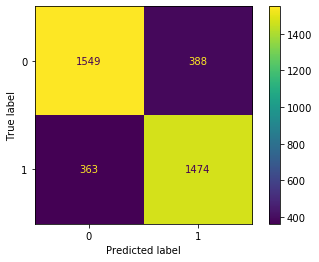

In [30]:
plot_confusion_matrix(ws_rf_cls, x_validation_mfcc, y_validation_mfcc, values_format='d')
plt.show()

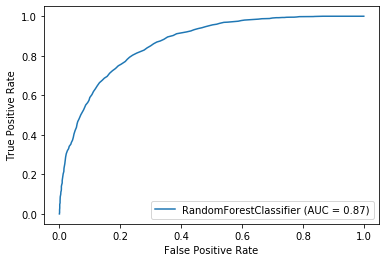

In [34]:
plot_roc_curve(ws_rf_cls, x_test_mfcc, y_test_mfcc)
plt.show()

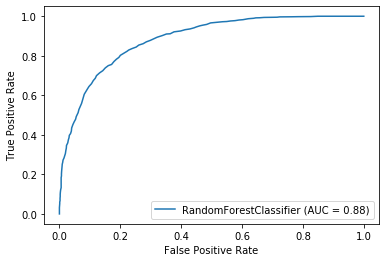

In [33]:
plot_roc_curve(ws_rf_cls, x_validation_mfcc, y_validation_mfcc)
plt.show()